In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import optimizers
from tensorflow.keras.layers import BatchNormalization

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split

device = torch.device("cuda")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import os
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#忽略所有的警告
import warnings
warnings.filterwarnings('ignore')

# 定义参数
IMG_SIZE_LENGTH = 224  # 图片大小
IMG_SIZE_WIDTH = 224
IMG_CHANNELS = 3  # 图片通道数
NUM_CLASSES = 4  # 类别数
BATCH_SIZE = 32  # 批次大小
EPOCHS_CNN = 50  # 训练轮数
EPOCHS_VGG = 15
EPOCHS_INC = 50
EPOCHS_RES = 50
EPOCHS_RES_pytorch = 30

LEARNING_RATE = 0.00001  # 学习率

# 定义文件夹路径
BASE_DIR = "base"  # 色泽良好的牙齿图片所在文件夹
TEST_DIR = "test"  # 色泽较深和较浅的牙齿图片所在文件夹
BASE_SUBDIR = "14"  # 色泽良好的牙齿图片所在子文件夹
TEST_SUBDIRS = ["13", "15", "16"]  # 色泽较深和较浅的牙齿图片所在子文件夹

# 定义类别标签和名称
LABELS = [0, 1, 2, 3]  # 标签值
NAMES = ["良好", "较浅", "较深", "深"]  # 标签名称

# 定义随机种子
SEED = 42  # 随机种子
np.random.seed(SEED)  # 设置NumPy随机种子
tf.random.set_seed(SEED)  # 设置TensorFlow随机种子

c:\Users\16490\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# 定义一个函数，用于从指定的文件夹中加载图片，并将它们转换为NumPy数组，同时给每个图片分配一个标签
def load_data(base_dir, test_dir, base_subdir, test_subdirs, img_size_length, img_size_width, img_channels, labels, names):
    # 初始化图片和标签列表
    images = []
    labels = []
        
    datagen = ImageDataGenerator(
        rotation_range=30,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # 遍历色泽良好的牙齿图片所在的子文件夹
    for filename in os.listdir(os.path.join(base_dir, base_subdir)):
        # 获取图片的完整路径
        img_path = os.path.join(base_dir, base_subdir, filename)
        # 打开图片并将其转换为RGB模式
        img = Image.open(img_path).convert("RGB")
        # 将图片调整为指定的大小
        img = img.resize((img_size_length, img_size_width))
        # 将图片转换为NumPy数组
        img = np.array(img)
        # 检查图片的形状是否符合要求
        assert img.shape == (img_size_length, img_size_width, img_channels)
        # 将图片添加到图片列表中
        images.append(img)
        # 将色泽良好的牙齿的标签值（0）添加到标签列表中
        labels.append(0)

    # 遍历色泽较深和较浅的牙齿图片所在的子文件夹
    for i, subdir in enumerate(test_subdirs):
        # 遍历每个子文件夹中的图片
        for filename in os.listdir(os.path.join(test_dir, subdir)):
            # 获取图片的完整路径
            img_path = os.path.join(test_dir, subdir, filename)
            # 打开图片并将其转换为RGB模式
            img = Image.open(img_path).convert("RGB")
            # 将图片调整为指定的大小
            img = img.resize((img_size_length, img_size_width))
            # 将图片转换为NumPy数组
            img = np.array(img)
            # 检查图片的形状是否符合要求
            assert img.shape == (img_size_length, img_size_width, img_channels)
            # 将图片添加到图片列表中
            images.append(img)
            # 将色泽较浅或较深或深的牙齿的标签值（1或2或3）添加到标签列表中
            labels.append(i + 1)

    # 在这里进行数据增强
    #for i in range(len(images)):
    #    img = images[i].reshape((1,) + images[i].shape)
    #    label = labels[i]
    #    for batch in datagen.flow(img, batch_size=1):
    #        batch = batch.reshape((img_size, img_size, img_channels))
    #        images.append(batch)
    #        labels.append(label)
    #        break  # 停止循环，否则生成器将无限制地产生图像

    # 将图片和标签列表转换为NumPy数组
    images = np.array(images)
    labels = np.array(labels)
    #print(images)
    #print(labels)
    # 返回图片和标签数组
    return images, labels

In [3]:
# 定义一个函数，用于可视化部分图片及其标签，以检查数据是否正确加载
def plot_data(images, labels, names, num_rows=3, num_cols=3):
    # 获取要显示的图片数量
    num_images = num_rows * num_cols
    # 创建一个画布对象
    fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))
    # 遍历每个子图位置
    for i in range(num_images):
        # 在画布上添加一个子图对象
        ax = fig.add_subplot(num_rows, num_cols, i + 1)
        # 随机选择一个图片索引
        idx = np.random.randint(len(images))
        # 获取对应的图片和标签
        image = images[idx]
        label = labels[idx]
        name = names[label]
        # 在子图上显示图片
        ax.imshow(image)
        # 在子图上显示标签名称
        ax.set_title(name)
        # 隐藏子图的坐标轴
        ax.axis("off")
    # 调整子图之间的间距
    fig.tight_layout()
    # 显示画布
    plt.show()

In [4]:
# 定义一个函数，用于对图片进行一些预处理，如缩放、归一化、打乱、划分等
def preprocess_data(images, labels, num_classes, batch_size, seed):
    # 将图片的数据类型转换为浮点数
    images = images.astype(np.float32)
    # 将图片的像素值缩放到0-1之间，以便于神经网络处理
    images = images / 255.0
    # 将标签的数据类型转换为整数
    labels = labels.astype(np.int32)
    # 将标签进行独热编码，即将每个标签转换为一个只有一个元素为1的向量
    #print(labels)
    labels = tf.keras.utils.to_categorical(labels, num_classes)
    
    # 使用SMOTE过采样方法平衡数据
    smote = SMOTE(random_state=seed)
    images_flat = images.reshape(len(images), -1)
    images_resampled, labels_resampled = smote.fit_resample(images_flat, labels)
    images_resampled = images_resampled.reshape(-1, images.shape[1], images.shape[2], images.shape[3])
    
    # 统计各标签的数据数量
    original_counts = np.sum(labels, axis=0)
    resampled_counts = np.sum(labels_resampled, axis=0)
    
    # 可视化数据数量的柱状图
    labels_list = list(range(num_classes))
    
    fig, ax = plt.subplots()
    bar_width = 0.35
    
    original_bar = ax.bar(labels_list, original_counts, bar_width, label='Original')
    resampled_bar = ax.bar(np.array(labels_list) + bar_width, resampled_counts, bar_width, label='Resampled')
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Counts')
    ax.set_title('Data Quantity Before and After SMOTE Resampling')
    ax.set_xticks(labels_list)
    ax.set_xticklabels(labels_list)
    ax.legend()
    
    
    
    # 随机打乱数据
    shuffle_indices = np.random.permutation(len(images_resampled))
    shuffled_images = images_resampled[shuffle_indices]
    shuffled_labels = labels_resampled[shuffle_indices]
    
    # 划分数据集
    train_images, val_images, test_images = np.split(shuffled_images, [int(0.8 * len(shuffled_images)), int(0.9 * len(shuffled_images))])
    train_labels, val_labels, test_labels = np.split(shuffled_labels, [int(0.8 * len(shuffled_labels)), int(0.9 * len(shuffled_labels))])
    
    # 将图像路径和标签信息转换为一维列表
    #train_image_paths = train_images.tolist()
    #val_image_paths = val_images.tolist()
    #test_image_path = test_images.tolist()
    train_label_list = train_labels.tolist()

    # 创建一个DataFrame来存储图像路径和标签信息
    #'image_path': train_image_paths,
    train_df = pd.DataFrame({'label': train_label_list})
    val_df = pd.DataFrame({'label': val_labels.tolist()})
    test_df = pd.DataFrame({'label': test_labels.tolist()})
    
    # 将数据保存为CSV文件
    train_df.to_csv('data/train.csv', index=False)
    val_df.to_csv('data/val.csv', index=False)
    test_df.to_csv('data/test.csv', index=False)
    
    # 创建数据集对象
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    # 打乱数据集
    train_dataset = train_dataset.shuffle(buffer_size=len(train_images), seed=seed)
    val_dataset = val_dataset.shuffle(buffer_size=len(val_images), seed=seed)
    test_dataset = test_dataset.shuffle(buffer_size=len(test_images), seed=seed)

    # 将数据集转换为批次处理的形式
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    # 返回处理后的数据集对象
    return train_dataset, val_dataset, test_dataset

In [5]:
# 定义一个函数，用于构建一个卷积神经网络（CNN）模型。
# 该模型的输出是一个四维向量，表示图片属于每个类别的概率
def build_model(img_size_length, img_size_width, img_channels, num_classes, learning_rate):
    # 创建一个Sequential模型对象，该对象可以将多个层按顺序堆叠起来
    model = tf.keras.Sequential()
    # 添加第一个卷积层，该层使用32个3x3的卷积核，以及ReLU激活函数，并使用L2正则化
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_size_length, img_size_width, img_channels), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # 添加第一个池化层，该层使用2x2的最大池化，以降低图片的尺寸和参数数量
    model.add(layers.MaxPooling2D((2, 2)))
    # 添加第一个批量归一化层，该层可以加速模型的收敛，并提高模型的泛化能力
    model.add(layers.BatchNormalization())
    # 添加第二个卷积层，该层使用64个3x3的卷积核，以及ReLU激活函数，并使用L2正则化
    model.add(layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # 添加第二个池化层，该层使用2x2的最大池化
    model.add(layers.MaxPooling2D((2, 2)))
    # 添加第二个批量归一化层
    model.add(layers.BatchNormalization())
    # 添加第三个卷积层，该层使用128个3x3的卷积核，以及ReLU激活函数，并使用L2正则化
    model.add(layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # 添加第三个池化层，该层使用2x2的最大池化
    model.add(layers.MaxPooling2D((2, 2)))
    # 添加第三个批量归一化层
    model.add(layers.BatchNormalization())
    # 添加第四个卷积层，该层使用256个3x3的卷积核，以及ReLU激活函数
    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    # 添加第四个池化层，该层使用2x2的最大池化
    model.add(layers.MaxPooling2D((2, 2)))
    # 添加第四个批量归一化层
    model.add(layers.BatchNormalization())
    # 添加一个展平层，该层可以将多维的张量展平为一维的向量，以便于后续的全连接层处理
    model.add(layers.Flatten())
    # 添加第一个全连接层，该层使用512个神经元，以及ReLU激活函数，并使用L2正则化
    model.add(layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # 添加第一个丢弃层，该层可以随机丢弃一些神经元，以防止模型过拟合
    model.add(layers.Dropout(0.5))
    # 添加第二个全连接层，该层使用512个神经元，以及ReLU激活函数
    model.add(layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # 添加第二个丢弃层
    model.add(layers.Dropout(0.5))
    # 添加第三个全连接层，该层使用num_classes个神经元，以及Softmax激活函数，作为模型的输出层
    model.add(layers.Dense(num_classes, activation="softmax"))
    # 定义模型的优化器、损失函数和评估指标
    optimizer = tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9))
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = ["accuracy"]
    # 编译模型
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    # 返回模型对象
    return model

In [6]:
# 构建预训练的VGG19模型（不包括顶层）
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE_LENGTH, IMG_SIZE_WIDTH, 3))

# 添加自定义的顶层
x = Flatten()(base_model_vgg.output)
#x = GlobalAveragePooling2D()(x) 
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# 创建新的模型
model_vgg = Model(inputs=base_model_vgg.input, outputs=x)

# 解冻预训练模型的权重
base_model_vgg.trainable = True

# 冻结预训练模型中不需要训练的层（例如前6层）
for layer in base_model_vgg.layers[:6]:
    layer.trainable = False

# 使用复杂的余弦退火学习率调度
cosine_annealing = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000
)

# 编译模型
optimizer = tf.keras.optimizers.AdamW(learning_rate=cosine_annealing, weight_decay=0.01)
#optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, momentum=0.9)
model_vgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# 加载预训练的 InceptionV3 模型，不包括顶层分类器
base_model_inc = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE_LENGTH, IMG_SIZE_WIDTH, 3))

# 添加全局平均池化层，以减少模型的参数数量
x = base_model_inc.output
x = GlobalAveragePooling2D()(x)

# 添加Batch Normalization层
x = BatchNormalization()(x)

# 添加一个全连接层
x = Dense(1024, activation='relu')(x)

# 添加Dropout层
x = Dropout(0.5)(x)

# 添加一个全连接层
x = Dense(512, activation='relu')(x)

# 添加Dropout层
x = Dropout(0.5)(x)

# 添加一个全连接层，用于您的分类任务，激活函数使用 softmax
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# 构建完整的模型
model_inc = Model(inputs=base_model_inc.input, outputs=predictions)

# 冻结 InceptionV3 的前 150 层
for layer in base_model_inc.layers[:150]:
    layer.trainable = False

# 对 InceptionV3 的后面一些层进行微调
for layer in base_model_inc.layers[150:]:
    layer.trainable = True
    
# 使用带动量法和学习率衰减的 Nesterov 动量梯度下降优化器
#opt = optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True)

# 使用带动量和学习率衰减的 Adam 优化器
#opt = Adam(learning_rate=LEARNING_RATE)

# 使用不同的优化器和学习率调度
opt = tf.keras.optimizers.SGD(learning_rate=tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000),
    momentum=0.9,
    nesterov=True)

# 编译模型
model_inc.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# 构建预训练的ResNet模型
def build_pretrained_resnet(img_size_length, img_size_width, num_classes, learning_rate):
    # 加载预训练的ResNet50模型
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size_length, img_size_width, 3))
    
    # 冻结所有预训练层
    for layer in base_model.layers:
        layer.trainable = False

    # 解冻最后三个残差块
    for layer in base_model.layers[:-11]:
        layer.trainable = True
    
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation=None),  # 减小隐藏层节点数
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),  # 减小Dropout比例
        layers.Dense(256, activation='relu'),  # 添加新的隐藏层
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # 使用AdamW优化器，并设置权重衰减
    # 使用学习率衰减
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                             decay_steps=1000,
                                                             decay_rate=0.9)
    optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)
    loss = keras.losses.CategoricalCrossentropy()
    metrics = ["accuracy"]
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# 创建预训练的ResNet模型
model_resnet = build_pretrained_resnet(IMG_SIZE_LENGTH, IMG_SIZE_WIDTH, NUM_CLASSES, LEARNING_RATE)

In [3]:
def build_resnet_pytorch_model(num_classes = NUM_CLASSES, learning_rate = LEARNING_RATE):
    # 构建resnet50_pytorch模型
    resnet_pytorch_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)  # 用预训练的权重来初始化
    num_features = resnet_pytorch_model.fc.in_features

    # 修改全连接层以适应新的类别数
    resnet_pytorch_model.fc = nn.Linear(num_features, num_classes)
    
    # 定义损失函数和优化器
    resnet_pytorch_criterion = nn.CrossEntropyLoss()
    resnet_pytorch_optimizer = optim.Adam(resnet_pytorch_model.parameters(), lr=learning_rate)
    
    return resnet_pytorch_model, resnet_pytorch_criterion, resnet_pytorch_optimizer

In [10]:
# 定义一个函数，用于训练模型，并使用验证集来评估模型的性能。该函数还会绘制训练过程中的损失和准确率曲线
def train_model(model, train_dataset, val_dataset, epochs):
    # 创建早停法对象
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    
    # 训练模型，并将训练过程中的信息保存在history对象中
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[early_stopping])
    
    # 获取训练过程中的损失和准确率值
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]
    
    # 创建一个画布对象
    fig = plt.figure(figsize=(12, 6))
    # 在画布上添加一个子图对象，用于显示损失曲线
    ax1 = fig.add_subplot(1, 2, 1)
    # 在子图上绘制训练集和验证集的损失值
    ax1.plot(train_loss, label="Train Loss")
    ax1.plot(val_loss, label="Val Loss")
    # 在子图上添加标题和坐标轴标签
    ax1.set_title("Loss Curve")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    # 在子图上添加图例
    ax1.legend()
    # 在画布上添加另一个子图对象，用于显示准确率曲线
    ax2 = fig.add_subplot(1, 2, 2)
    # 在子图上绘制训练集和验证集的准确率值
    ax2.plot(train_acc, label="Train Accuracy")
    ax2.plot(val_acc, label="Val Accuracy")
    # 在子图上添加标题和坐标轴标签
    ax2.set_title("Accuracy Curve")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    # 在子图上添加图例
    ax2.legend()
    # 调整子图之间的间距
    fig.tight_layout()
    # 显示画布
    plt.show()

In [11]:
def train_resnet_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=EPOCHS_RES_pytorch):
    best_loss = 1e100
    model.to(device)

    # 用于保存训练和验证过程中的损失和准确率
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        trcorrect = 0
        trtotal = 0

        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # 清除所有累积梯度
            optimizer.zero_grad()

            # 数据预处理
            images = images.permute(0, 3, 1, 2).contiguous()
            images = images.float()

            # 前向传播
            outputs = model(images)
            
            #print(outputs.shape)  # 应该是 [batch_size, num_classes]
            #print(outputs)
            #print(labels.shape)  # 应该是 [batch_size]
            #print(labels)

            # 计算损失
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, trpredicted = outputs.max(1)
            trtotal += labels.size(0)
            trcorrect += trpredicted.eq(labels).sum().item()
            
        train_loss = running_loss / len(train_dataloader)
        train_accuracy = trcorrect / trtotal

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        valcorrect = 0
        valtotal = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)
    
                # 数据预处理
                images = images.permute(0, 3, 1, 2).contiguous()
                images = images.float()

                # 前向传播
                outputs = model(images)

                # 计算损失
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, valpredicted = torch.max(outputs, 1)
                valtotal += labels.size(0)
                valcorrect += valpredicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(val_dataloader)
        val_accuracy = valcorrect / valtotal
        
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_accuracy)

        # 输出训练信息
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {val_epoch_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
        
        if val_epoch_loss < best_loss:
            torch.save(model.state_dict(), 'model/model_resnet_pytorch.pth')
            
    # 可视化训练过程中的损失和准确率
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(train_losses, label="Train Loss")
    ax1.plot(val_losses, label="Val Loss")
    ax1.set_title("Loss Curve")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(train_accuracies, label="Train Accuracy")
    ax2.plot(val_accuracies, label="Val Accuracy")
    ax2.set_title("Accuracy Curve")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
    fig.tight_layout()
    plt.show()
    return model

In [5]:
# 定义一个函数，用于在测试集上测试模型，并计算模型的准确率、混淆矩阵、分类报告等指标
def test_model(model, test_dataset, names):
    # 初始化预测和真实标签列表
    predictions = []
    true_labels = []
    # 遍历测试集中的每个批次
    for images, labels in test_dataset:
        # 使用模型对图片进行预测，并获取预测的概率向量
        probs = model.predict(images)
        # 将概率向量转换为标签值，即取概率最大的元素的索引
        preds = np.argmax(probs, axis=1)
        # 将标签值添加到预测列表中
        predictions.extend(preds)
        # 将真实的标签值（独热编码）转换为标签值，即取为1的元素的索引
        labels = np.argmax(labels, axis=1)
        # 将真实的标签值添加到真实标签列表中
        true_labels.extend(labels)
    # 计算模型在测试集上的准确率
    acc = accuracy_score(true_labels, predictions)
    # 打印准确率
    print(f"Test Accuracy: {acc:.4f}")
    # 计算模型在测试集上的混淆矩阵
    cm = confusion_matrix(true_labels, predictions)
    # 打印混淆矩阵
    print(f"Confusion Matrix:\n{cm}")
    # 计算模型在测试集上的分类报告，包括每个类别的精确率、召回率、F1分数等指标
    cr = classification_report(true_labels, predictions, target_names=names)
    # 打印分类报告
    print(f"Classification Report:\n{cr}")

In [20]:
def test_model_resnet(model, test_loader, names):
    # 使模型进入评估模式
    model.eval()

    # 初始化预测和真实标签列表
    predictions = []
    true_labels = []

    # 在测试集上遍历每个批次
    with torch.no_grad():  # 关闭梯度计算，节省内存并加速计算
        for images, labels in test_loader:
            # 转换输入数据的维度
            images = images.permute(0, 3, 1, 2).float().to(device)
            labels = labels.to(device)
            
            # 使用模型进行预测，并获得输出
            outputs = model(images)
            
            # 获取预测的标签
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

            # 将真实的标签值添加到真实标签列表中
            true_labels.extend(labels.cpu().numpy())

    # 计算模型在测试集上的准确率
    acc = accuracy_score(true_labels, predictions)

    # 打印准确率
    print(f"测试准确率: {acc:.4f}")

    # 计算模型在测试集上的混淆矩阵
    cm = confusion_matrix(true_labels, predictions)

    # 打印混淆矩阵
    print(f"混淆矩阵:\n{cm}")

    # 计算模型在测试集上的分类报告
    cr = classification_report(true_labels, predictions, target_names=names)

    # 打印分类报告
    print(f"分类报告:\n{cr}")

In [13]:
# 定义一个函数，用于从模型中提取最后一个卷积层的输出作为图片的色泽特征，并计算每个类别的平均色泽特征
def extract_features(model, images, labels):
    # 获取模型中最后一个卷积层的名称
    layer_name = model.layers[-6].name
    # 创建一个新的模型对象，该对象以原模型的输入为输入，以最后一个卷积层的输出为输出
    feature_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    # 使用新模型对图片进行预测，并获取最后一个卷积层的输出，即图片的色泽特征
    features = feature_model.predict(images)
    # 将色泽特征展平为一维向量，并将其转换为NumPy数组
    features = features.reshape(features.shape[0], -1)
    features = np.array(features)
    # 将标签值（独热编码）转换为标签值，即取为1的元素的索引，并将其转换为NumPy数组
    #labels = np.argmax(labels, axis=1)
    labels = np.argmax(labels)
    labels = np.array(labels)
    # 初始化每个类别的平均色泽特征列表
    mean_features = []
    # 遍历每个类别
    for i in range(NUM_CLASSES):
        # 获取该类别的图片的索引
        indices = np.where(labels == i)[0]
        # 获取该类别的图片的色泽特征
        class_features = features[indices]
        # 计算该类别的图片的平均色泽特征
        class_mean = np.mean(class_features, axis=0)
        # 将该类别的平均色泽特征添加到列表中
        mean_features.append(class_mean)
    # 将每个类别的平均色泽特征列表转换为NumPy数组
    mean_features = np.array(mean_features)
    # 返回图片的色泽特征和每个类别的平均色泽特征
    return features, mean_features

In [6]:
# 调用load_data函数，加载图片和标签数据
images, labels = load_data(BASE_DIR, TEST_DIR, BASE_SUBDIR, TEST_SUBDIRS, IMG_SIZE_LENGTH, IMG_SIZE_WIDTH, IMG_CHANNELS, LABELS, NAMES)
# 打印图片和标签数据的形状
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (400, 224, 224, 3)
Labels shape: (400,)


In [8]:
# 将图片和标签数组转换为torch张量
images_resnet = torch.from_numpy(images)
labels_resnet = torch.from_numpy(labels).long()

# 将图片和标签张量组合成一个数据集对象
tooth_dataset_resnet = torch.utils.data.TensorDataset(images_resnet, labels_resnet)

# 数据集划分
# 划分为训练集、验证集、测试集
dataset_size_resnet = len(tooth_dataset_resnet)
train_size_resnet = int(0.7 * dataset_size_resnet)
val_size_resnet = int(0.2 * dataset_size_resnet)
test_size_resnet = dataset_size_resnet - train_size_resnet - val_size_resnet

# 使用random_split来随机打乱并划分数据集
train_dataset_resnet, val_dataset_resnet, test_dataset_resnet = random_split(tooth_dataset_resnet, [train_size_resnet, val_size_resnet, test_size_resnet])

train_dataloader_resnet = DataLoader(dataset=train_dataset_resnet, batch_size=32, shuffle=True)
val_dataloader_resnet = DataLoader(dataset=val_dataset_resnet, batch_size=32, shuffle=False)
test_dataloader_resnet = DataLoader(dataset=test_dataset_resnet, batch_size=32, shuffle=False)

# 打印图片和标签数据的形状
print(f"Images shape: {images_resnet.shape}")
print(f"Labels shape: {labels_resnet.shape}")
print(f"Images dtype: {images_resnet.dtype}")
print(f"Labels dtype: {labels_resnet.dtype}")

Images shape: torch.Size([400, 224, 224, 3])
Labels shape: torch.Size([400])
Images dtype: torch.uint8
Labels dtype: torch.int64


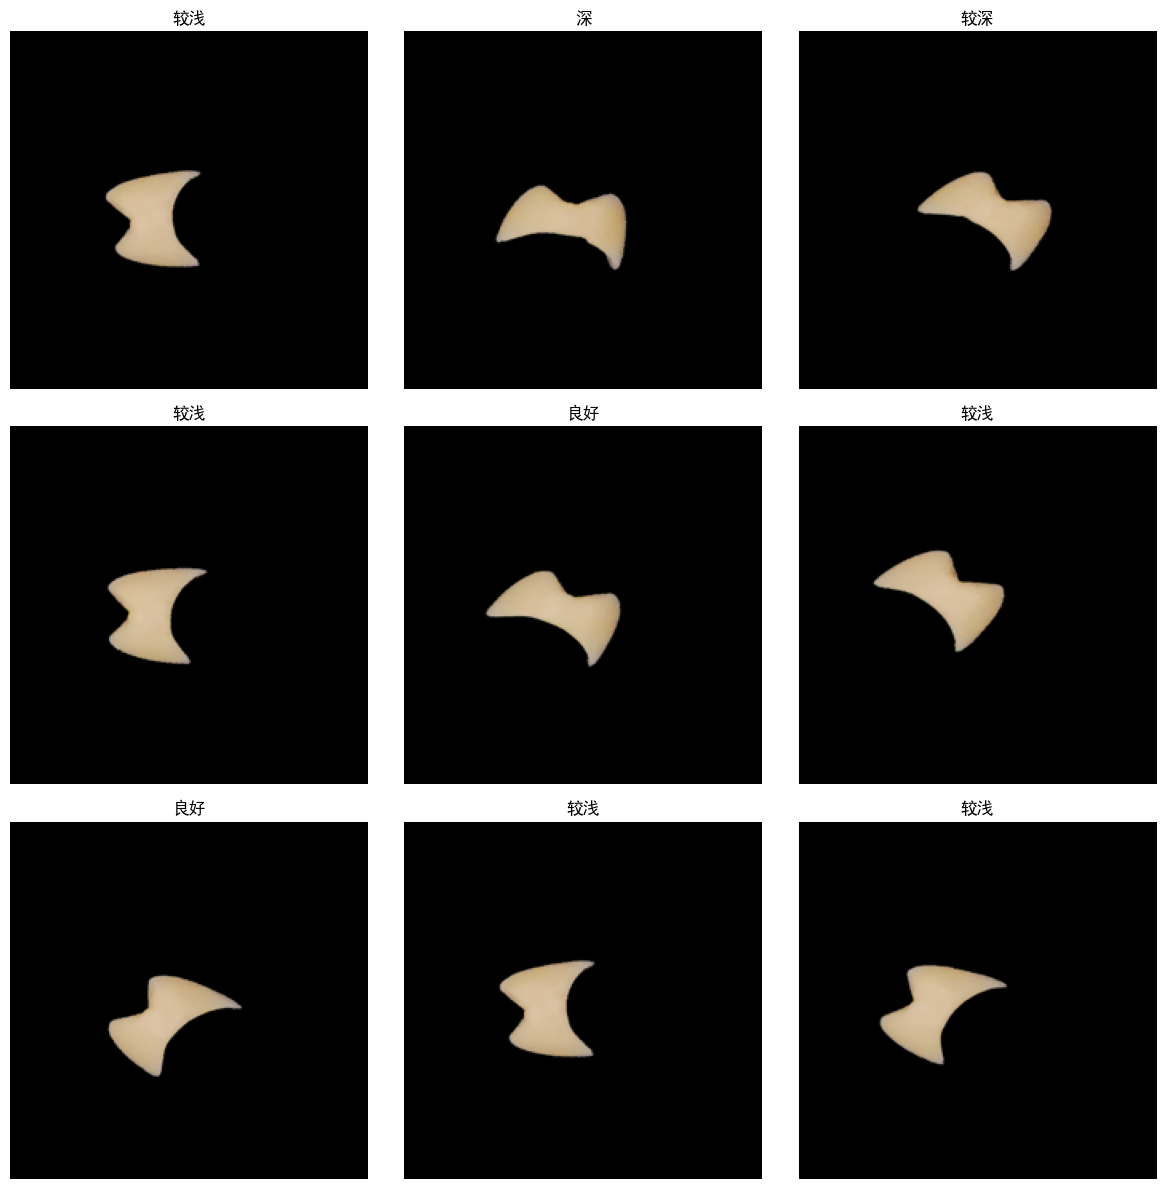

In [16]:
# 调用plot_data函数，可视化部分图片及其标签
plot_data(images, labels, NAMES)

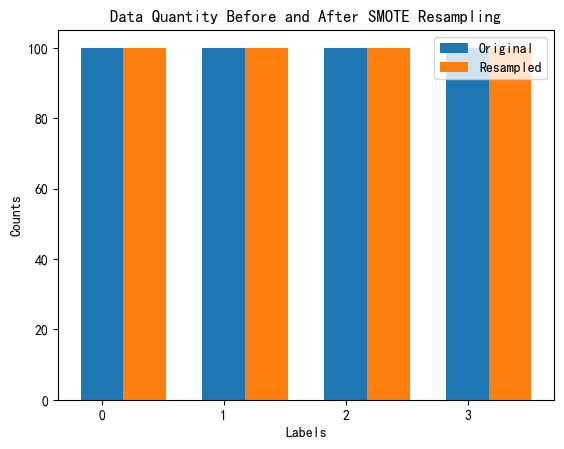

In [17]:
# 调用preprocess_data函数，对图片和标签进行预处理，并划分为训练集、验证集和测试集
train_dataset, val_dataset, test_dataset = preprocess_data(images, labels, NUM_CLASSES, BATCH_SIZE, SEED)

In [18]:
# 调用build_model函数，构建卷积神经网络模型
model = build_model(IMG_SIZE_LENGTH, IMG_SIZE_WIDTH, IMG_CHANNELS, NUM_CLASSES, LEARNING_RATE)
# 打印模型的架构
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_98 (Ba  (None, 111, 111, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_95 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                      

In [19]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
# 输出模型的摘要
model_inc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization_1[

In [21]:
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_96 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_97 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                        

Epoch 1/50


10/10 [==============================] - 28s 3s/step - loss: 29.9951 - accuracy: 0.3594 - val_loss: 29.4190 - val_accuracy: 0.4250
Epoch 2/50
10/10 [==============================] - 27s 3s/step - loss: 28.9233 - accuracy: 0.6313 - val_loss: 29.3869 - val_accuracy: 0.3000
Epoch 3/50
10/10 [==============================] - 27s 3s/step - loss: 28.5457 - accuracy: 0.7875 - val_loss: 29.3507 - val_accuracy: 0.2750
Epoch 4/50
10/10 [==============================] - 28s 3s/step - loss: 28.3279 - accuracy: 0.8438 - val_loss: 29.3007 - val_accuracy: 0.2750
Epoch 5/50
10/10 [==============================] - 27s 3s/step - loss: 28.2458 - accuracy: 0.8250 - val_loss: 29.2381 - val_accuracy: 0.2750
Epoch 6/50
10/10 [==============================] - 28s 3s/step - loss: 28.0878 - accuracy: 0.8813 - val_loss: 29.1731 - val_accuracy: 0.2750
Epoch 7/50
10/10 [==============================] - 27s 3s/step - loss: 27.9918 - accuracy: 0.9000 - val_loss: 29.0943 - val_accuracy: 0.2750
Epoch 8/50
10/10 

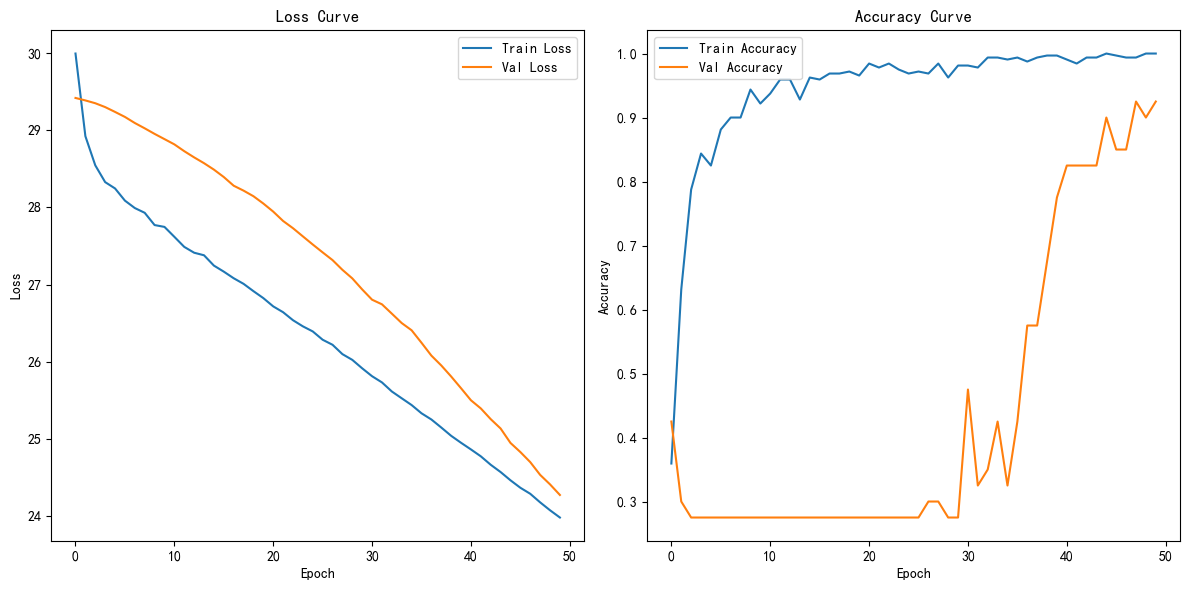

In [22]:
# 调用train_model函数，训练CNN模型，并可视化训练过程中的损失和准确率曲线
train_model(model, train_dataset, val_dataset, EPOCHS_CNN)

In [26]:

# 调用test_model函数，测试CNN模型在测试集上的性能，并打印准确率、混淆矩阵和分类报告
test_model(model, test_dataset, NAMES)

1/1 [==============================] - 0s 143ms/step
Test Accuracy: 0.9000
Confusion Matrix:
[[ 4  0  0  4]
 [ 0 11  0  0]
 [ 0  0  8  0]
 [ 0  0  0 13]]
Classification Report:
              precision    recall  f1-score   support

          良好       1.00      0.50      0.67         8
          较浅       1.00      1.00      1.00        11
          较深       1.00      1.00      1.00         8
           深       0.76      1.00      0.87        13

    accuracy                           0.90        40
   macro avg       0.94      0.88      0.88        40
weighted avg       0.92      0.90      0.89        40



In [24]:
# 保存CNN模型结构（架构）到 JSON 文件：
model_json_CNN = model.to_json()
with open("model/model_CNN_architecture.json", "w") as json_file_CNN:
    json_file_CNN.write(model_json_CNN)

# 保存模型权重到 HDF5 文件：
model.save_weights("model/model_CNN_weights.h5")

Epoch 1/15


10/10 [==============================] - 210s 21s/step - loss: 0.5777 - accuracy: 0.7906 - val_loss: 1.0953 - val_accuracy: 0.4750
Epoch 2/15
10/10 [==============================] - 221s 22s/step - loss: 0.2077 - accuracy: 0.9563 - val_loss: 0.9897 - val_accuracy: 0.8250
Epoch 3/15
10/10 [==============================] - 212s 21s/step - loss: 0.0907 - accuracy: 0.9906 - val_loss: 0.9201 - val_accuracy: 0.8500
Epoch 4/15
10/10 [==============================] - 211s 21s/step - loss: 0.0519 - accuracy: 1.0000 - val_loss: 0.8616 - val_accuracy: 0.9750
Epoch 5/15
10/10 [==============================] - 212s 21s/step - loss: 0.0363 - accuracy: 0.9969 - val_loss: 0.8196 - val_accuracy: 0.9000
Epoch 6/15
10/10 [==============================] - 225s 23s/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.7829 - val_accuracy: 0.9250
Epoch 7/15
10/10 [==============================] - 215s 22s/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.7333 - val_accuracy: 0.9500
Epoch 8/15
10/10 

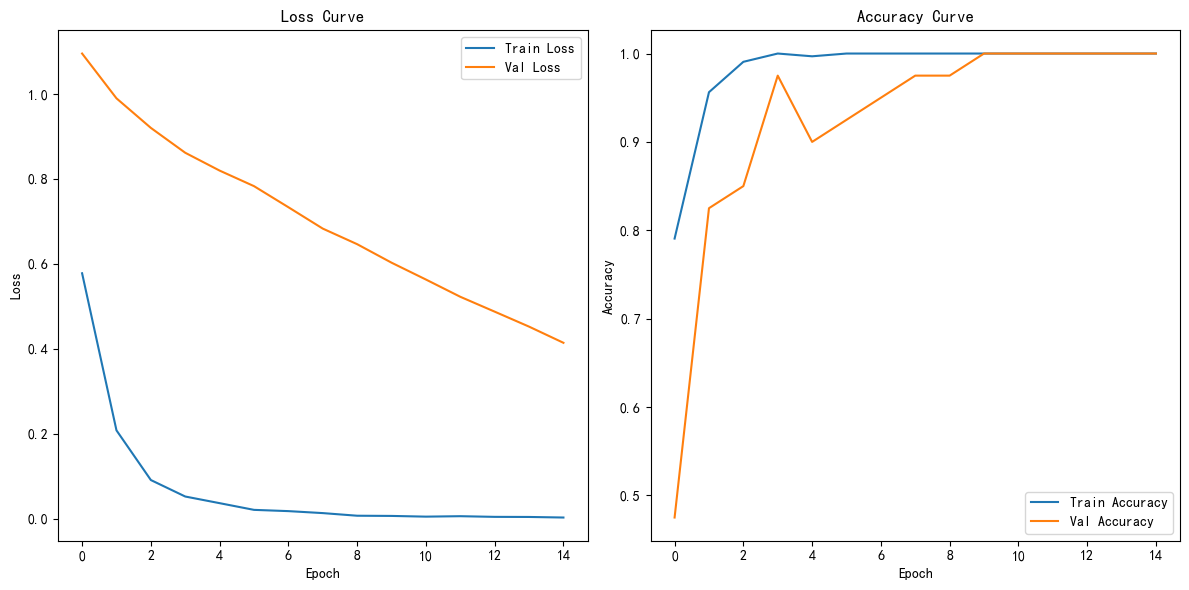

In [27]:
# 调用train_model函数，训练VGG模型，并可视化训练过程中的损失和准确率曲线
train_model(model_vgg, train_dataset, val_dataset, EPOCHS_VGG)

In [28]:

# 调用test_model函数，测试VGG模型在测试集上的性能，并打印准确率、混淆矩阵和分类报告
test_model(model_vgg, test_dataset, NAMES)

1/1 [==============================] - 2s 2s/step
Test Accuracy: 1.0000
Confusion Matrix:
[[ 8  0  0  0]
 [ 0 11  0  0]
 [ 0  0  8  0]
 [ 0  0  0 13]]
Classification Report:
              precision    recall  f1-score   support

          良好       1.00      1.00      1.00         8
          较浅       1.00      1.00      1.00        11
          较深       1.00      1.00      1.00         8
           深       1.00      1.00      1.00        13

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [29]:
# 保存VGG模型结构（架构）到 JSON 文件：
model_json_vgg = model_vgg.to_json()
with open("model/model_vgg_architecture.json", "w") as json_file_vgg:
    json_file_vgg.write(model_json_vgg)

# 保存模型权重到 HDF5 文件：
model_vgg.save_weights("model/model_vgg_weights.h5")

Epoch 1/50
10/10 [==============================] - 47s 4s/step - loss: 2.6962 - accuracy: 0.2812 - val_loss: 1.3401 - val_accuracy: 0.4000
Epoch 2/50
10/10 [==============================] - 40s 4s/step - loss: 2.5640 - accuracy: 0.3063 - val_loss: 1.3129 - val_accuracy: 0.4250
Epoch 3/50
10/10 [==============================] - 41s 4s/step - loss: 2.1570 - accuracy: 0.3094 - val_loss: 1.2947 - val_accuracy: 0.3750
Epoch 4/50
10/10 [==============================] - 41s 4s/step - loss: 1.9792 - accuracy: 0.3344 - val_loss: 1.3003 - val_accuracy: 0.4500
Epoch 5/50
10/10 [==============================] - 42s 4s/step - loss: 1.7668 - accuracy: 0.3844 - val_loss: 1.3039 - val_accuracy: 0.4500
Epoch 6/50
10/10 [==============================] - 43s 4s/step - loss: 1.7653 - accuracy: 0.4250 - val_loss: 1.2877 - val_accuracy: 0.4250
Epoch 7/50
10/10 [==============================] - 41s 4s/step - loss: 1.5006 - accuracy: 0.4219 - val_loss: 1.2699 - val_accuracy: 0.4250
Epoch 8/50
10/10 [==

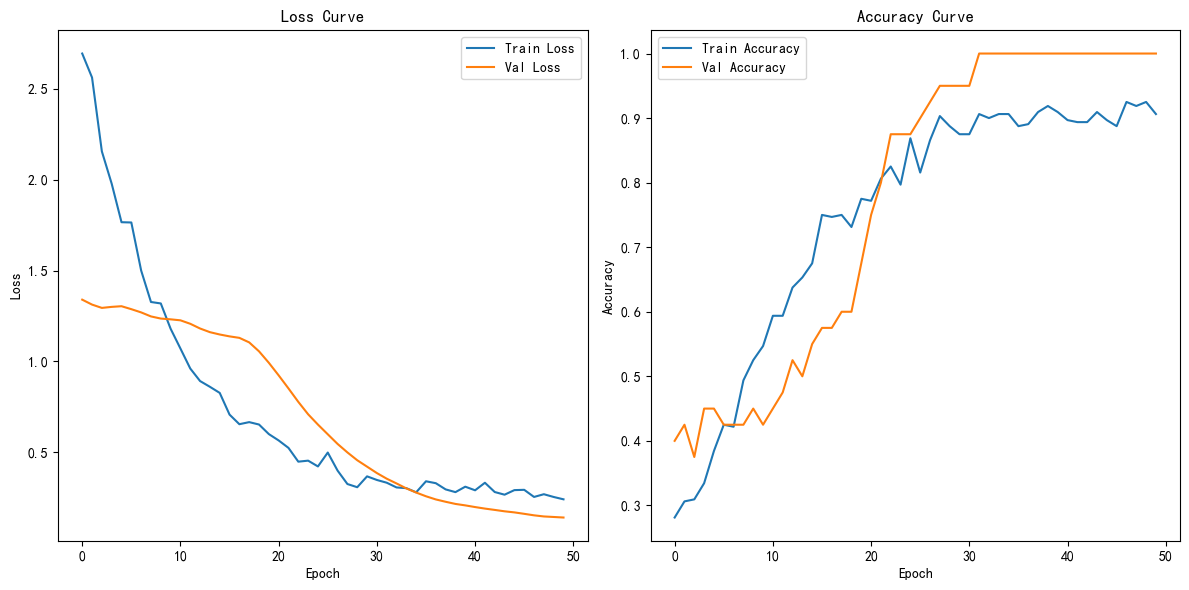

In [30]:
# 调用train_model函数，训练Inception模型，并可视化训练过程中的损失和准确率曲线
train_model(model_inc, train_dataset, val_dataset, EPOCHS_INC)

In [31]:
# 调用test_model函数，测试Inception模型在测试集上的性能，并打印准确率、混淆矩阵和分类报告
test_model(model_inc, test_dataset, NAMES)

1/1 [==============================] - 2s 2s/step
Test Accuracy: 1.0000
Confusion Matrix:
[[ 8  0  0  0]
 [ 0 11  0  0]
 [ 0  0  8  0]
 [ 0  0  0 13]]
Classification Report:
              precision    recall  f1-score   support

          良好       1.00      1.00      1.00         8
          较浅       1.00      1.00      1.00        11
          较深       1.00      1.00      1.00         8
           深       1.00      1.00      1.00        13

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [32]:
# 保存Inception模型结构（架构）到 JSON 文件：
model_json_inc = model_inc.to_json()
with open("model/model_inc_architecture.json", "w") as json_file_inc:
    json_file_inc.write(model_json_inc)

# 保存模型权重到 HDF5 文件：
model_inc.save_weights("model/model_inc_weights.h5")

Epoch 1/50
10/10 [==============================] - 143s 14s/step - loss: 1.8322 - accuracy: 0.3063 - val_loss: 1.4697 - val_accuracy: 0.2750
Epoch 2/50
10/10 [==============================] - 136s 14s/step - loss: 1.5343 - accuracy: 0.3469 - val_loss: 1.3814 - val_accuracy: 0.2750
Epoch 3/50
10/10 [==============================] - 133s 13s/step - loss: 1.2291 - accuracy: 0.4875 - val_loss: 1.3329 - val_accuracy: 0.4000
Epoch 4/50
10/10 [==============================] - 125s 12s/step - loss: 1.0541 - accuracy: 0.5562 - val_loss: 1.3457 - val_accuracy: 0.4000
Epoch 5/50
10/10 [==============================] - 122s 12s/step - loss: 0.8891 - accuracy: 0.6250 - val_loss: 1.3750 - val_accuracy: 0.4000
Epoch 6/50
10/10 [==============================] - 120s 12s/step - loss: 0.7657 - accuracy: 0.7063 - val_loss: 1.3894 - val_accuracy: 0.4000
Epoch 7/50
10/10 [==============================] - 121s 12s/step - loss: 0.7165 - accuracy: 0.7250 - val_loss: 1.3979 - val_accuracy: 0.4000
Epoch 

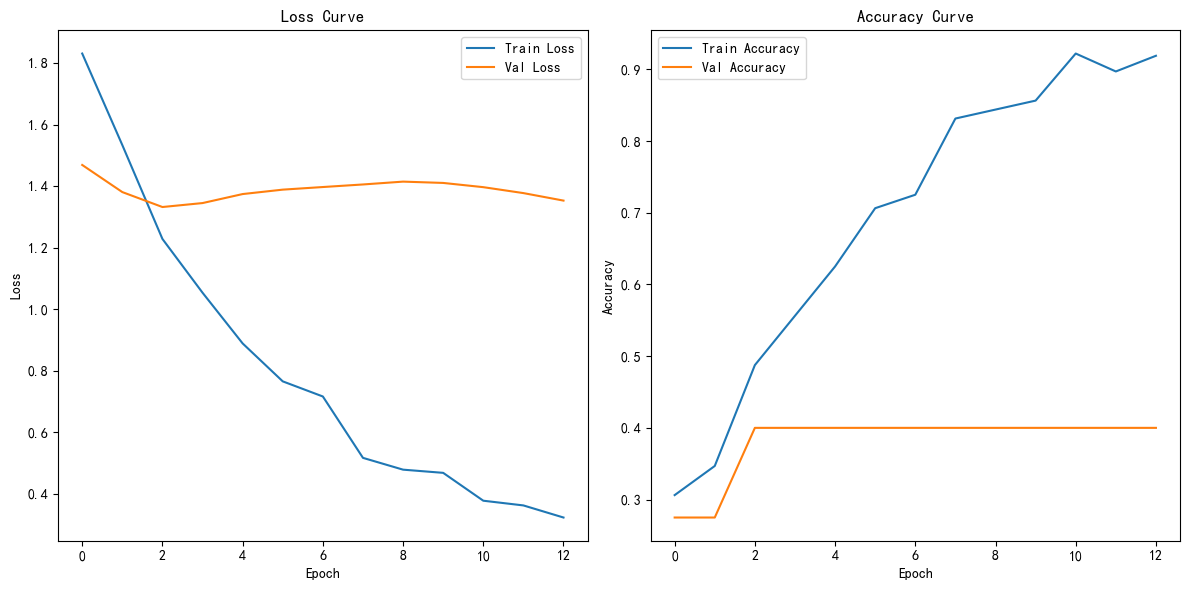

In [33]:
# 调用train_model函数，训练Resnet模型，并可视化训练过程中的损失和准确率曲线
train_model(model_resnet, train_dataset, val_dataset, EPOCHS_RES)

In [34]:

# 调用test_model函数，测试ResNet模型在测试集上的性能，并打印准确率、混淆矩阵和分类报告
test_model(model_resnet, test_dataset, NAMES)

1/1 [==============================] - 2s 2s/step
Test Accuracy: 0.2000
Confusion Matrix:
[[ 0  0  8  0]
 [ 0  0 11  0]
 [ 0  0  8  0]
 [ 0  0 13  0]]
Classification Report:
              precision    recall  f1-score   support

          良好       0.00      0.00      0.00         8
          较浅       0.00      0.00      0.00        11
          较深       0.20      1.00      0.33         8
           深       0.00      0.00      0.00        13

    accuracy                           0.20        40
   macro avg       0.05      0.25      0.08        40
weighted avg       0.04      0.20      0.07        40



In [35]:
# 保存ResNet模型结构（架构）到 JSON 文件：
model_json_resnet = model_resnet.to_json()
with open("model/model_resnet_architecture.json", "w") as json_file_resnet:
    json_file_resnet.write(model_json_resnet)

# 保存模型权重到 HDF5 文件：
model_resnet.save_weights("model/model_resnet_weights.h5")

Epoch 1/30 - loss: 1.3638 - accuracy: 0.3679 - val_loss: 1.3852 - val_accuracy: 0.2000
Epoch 2/30 - loss: 1.3038 - accuracy: 0.6857 - val_loss: 1.3756 - val_accuracy: 0.3000
Epoch 3/30 - loss: 1.2407 - accuracy: 0.8286 - val_loss: 1.3425 - val_accuracy: 0.5125
Epoch 4/30 - loss: 1.1695 - accuracy: 0.9107 - val_loss: 1.2883 - val_accuracy: 0.5500
Epoch 5/30 - loss: 1.0844 - accuracy: 0.9464 - val_loss: 1.2197 - val_accuracy: 0.5875
Epoch 6/30 - loss: 0.9987 - accuracy: 0.9536 - val_loss: 1.1212 - val_accuracy: 0.7750
Epoch 7/30 - loss: 0.8991 - accuracy: 0.9821 - val_loss: 1.0446 - val_accuracy: 0.7875
Epoch 8/30 - loss: 0.8013 - accuracy: 1.0000 - val_loss: 0.9982 - val_accuracy: 0.7250
Epoch 9/30 - loss: 0.7046 - accuracy: 0.9929 - val_loss: 1.1290 - val_accuracy: 0.3875
Epoch 10/30 - loss: 0.6480 - accuracy: 1.0000 - val_loss: 0.9096 - val_accuracy: 0.8125
Epoch 11/30 - loss: 0.5621 - accuracy: 0.9964 - val_loss: 0.8004 - val_accuracy: 0.8375
Epoch 12/30 - loss: 0.5131 - accuracy: 0.

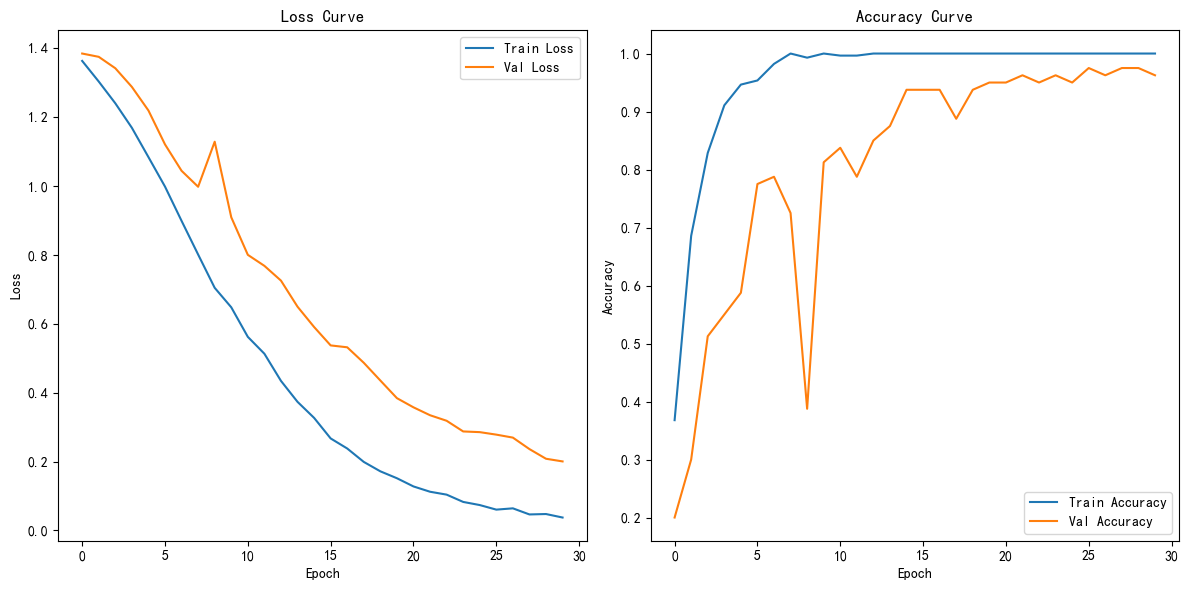

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# 定义设备，如果有可用的CUDA则使用GPU，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 调用train_model函数，训练Resnet_Pytorch模型，并计算训练过程中的损失
model_resnet_pytorch, criterion_resnet_pytorch, optimizer_resnet_pytorch = build_resnet_pytorch_model(num_classes = NUM_CLASSES, learning_rate = LEARNING_RATE)
train_resnet_model(model_resnet_pytorch, train_dataloader_resnet, val_dataloader_resnet, criterion_resnet_pytorch, optimizer_resnet_pytorch, device, num_epochs = EPOCHS_RES_pytorch)

In [21]:
#调用test_model函数，测试ResNet模型在测试集上的性能，并打印准确率、混淆矩阵和分类报告
test_model_resnet(model_resnet_pytorch, test_dataloader_resnet, NAMES)

测试准确率: 1.0000
混淆矩阵:
[[ 9  0  0  0]
 [ 0 11  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
分类报告:
              precision    recall  f1-score   support

          良好       1.00      1.00      1.00         9
          较浅       1.00      1.00      1.00        11
          较深       1.00      1.00      1.00        10
           深       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [ ]:
# 调用extract_features函数，提取图片的色泽特征和每个类别的平均色泽特征
features, mean_features = extract_features(model_vgg, images, labels)
# 打印图片的色泽特征和每个类别的平均色泽特征的形状
print(f"Image Features shape: {features.shape}")
print(f"Mean Features shape: {mean_features.shape}")

In [ ]:
from tensorflow.keras.models import model_from_json

# 加载模型结构（架构）：
with open("model/model_vgg_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# 加载模型权重：
loaded_model.load_weights("model/model_vgg_weights.h5")